# thal2 get tables for xpp

1. Manually create XPP-compatible tables for the $\mathcal{H}$-functions.
2. Get Fourier coefficients for $\mathcal{H}$-functions (might not implement. we'll see)
3. Output LaTeX compatible plain text.

To create XPP-compatible tables, recall from [here](https://sites.pitt.edu/~phase/bard/bardware/xpp/help/xppodes.html): that we require the format:

```
npts
xlo
xhi
y(xlo)
...
y(xhi)
```

The domain of the function is `[xlo,xhi]`

In XPP, the format to load the file is given by,

`table name filename`



**Fourier notes**

Recall: Given the fourier coefficients $c_n$ for $n \in\mathbb{Z}$ and supposing that $c_n = a_n + i b_n$, the real Fourier series is given by,
$$\sum_{n =1}^\infty 2 a_n \cos(n \omega t) - 2 b_n \sin(n \omega t).$$
So I really only need to save the coefficients for positive frequencies and double them. 

Goal: given a function, display a list of coefficients (maybe implement text output to copy/past into XPP)

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import get_phase, bif1d, follow_phase_diffs

from lib.rhs import _redu_c2,_full, _redu_full

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
data_dir = 'xpp_tables/'
if not(os.path.isdir(data_dir)):
    os.mkdir(data_dir)

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def get_coeffs(data,threshold = 0.1):
    coeffs = np.fft.fft(data)
    
    # get coeffs above threshold
    NH = len(data)
    
    coeffs_re_all = np.real(coeffs)
    coeffs_im_all = np.imag(coeffs)
    nn = np.arange(len(coeffs),dtype='int')
    
    coeffs_re_bool = (np.abs(coeffs_re_all) > threshold)*(nn<NH/2)
    coeffs_im_bool = (np.abs(coeffs_im_all) > threshold)*(nn<NH/2)
    
    freqs = np.fft.fftfreq(len(coeffs),d=(1/a.NH))
    
    coeffs_re = coeffs_re_all[coeffs_re_bool]
    coeffs_im = coeffs_im_all[coeffs_im_bool]
    
    freqs[coeffs_re_bool]

    return coeffs_re, coeffs_im, freqs[coeffs_re_bool], freqs[coeffs_im_bool]

def call_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    tot = 0
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            tot += c/a.NH
        else:
            tot += 2*c*np.cos(a.x*fr[i])/a.NH
    
    for i,c in enumerate(coeffs_im):
        tot += -2*c*np.sin(a.x*fi[i])/a.NH

    return tot

def print_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    # display copy/paste-able equation
    eq = ''
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            eq += '{:.4f}'.format(c/a.NH)
        else:
            eq += '+2*cos(x*{})*({:.4f})'.format(fr[i],c/a.NH)
    
    for i,c in enumerate(coeffs_im):
        eq += '-2*sin(x*{})*({:.4f})'.format(fi[i],c/a.NH)
        #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a.NH
    return eq


In [10]:
def print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi):
    # display copy/paste-able equation
    eq = ''
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            eq += '{:.4f}'.format(c/a.NH)
        else:
            coeff = 2*c/a.NH
            if coeff < 0:
                sign = '-'
            else:
                sign = '+'
            eq += sign+'{:.4f}\\cos({}x) '.format(abs(coeff),int(fr[i]))
    
    for i,c in enumerate(coeffs_im):
        coeff = -2*c/a.NH
        if coeff < 0:
            sign = '-'
        else:
            sign = '+'
        eq += sign+'{:.4f}\\sin({}x) '.format(abs(coeff),int(fi[i]))
        #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a.NH
    return eq


## Initialize Response Functions

In [12]:
system1 = rsp(idx=0,model_name='thal0_85',**kws1)
system2 = rsp(idx=1,model_name='thal1_85',**kws1)

mkdir ./data/thal0_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 1:1

In [13]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',1),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,100], # [eps, eps^2, etc]
        }
a11 = nm.nmCoupling(**kw_nm)

Initializing 11 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## A

### eps

In [14]:
a = a11
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
# print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2387+2*cos(x*1.0)*(-0.1298)+2*cos(x*2.0)*(-0.0087)+2*cos(x*3.0)*(0.0046)+2*cos(x*4.0)*(0.0025)+2*cos(x*5.0)*(0.0010)-2*sin(x*1.0)*(0.0332)-2*sin(x*3.0)*(-0.0049)-2*sin(x*4.0)*(-0.0020)

het osc 1 order 1, c1 -5.9757


### eps^2

In [15]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.1270+2*cos(x*1.0)*(0.0104)+2*cos(x*2.0)*(-0.0730)+2*cos(x*3.0)*(-0.0175)+2*cos(x*4.0)*(0.0082)+2*cos(x*5.0)*(0.0058)+2*cos(x*6.0)*(0.0018)-2*sin(x*1.0)*(-0.0021)-2*sin(x*2.0)*(0.0206)-2*sin(x*3.0)*(0.0051)-2*sin(x*4.0)*(-0.0068)-2*sin(x*5.0)*(-0.0046)-2*sin(x*6.0)*(-0.0010)

het osc 1 order 2, c1 -0.1353+2*cos(x*1.0)*(0.1943)+2*cos(x*2.0)*(0.0255)+2*cos(x*3.0)*(-0.0796)+2*cos(x*4.0)*(-0.0446)-2*sin(x*1.0)*(0.8082)-2*sin(x*2.0)*(0.1118)-2*sin(x*3.0)*(-0.0845)-2*sin(x*4.0)*(-0.0591)-2*sin(x*5.0)*(-0.0289)-2*sin(x*6.0)*(-0.0140)

het osc 1 order 2, c2 -595.9792


## B

### eps

In [16]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2387+2*cos(x*1.0)*(-0.1298)+2*cos(x*2.0)*(-0.0087)+2*cos(x*3.0)*(0.0046)+2*cos(x*4.0)*(0.0025)+2*cos(x*5.0)*(0.0010)-2*sin(x*1.0)*(-0.0332)-2*sin(x*3.0)*(0.0049)-2*sin(x*4.0)*(0.0020)

het osc 2 order 1, c1 


### eps^2

In [17]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.1270+2*cos(x*1.0)*(0.0104)+2*cos(x*2.0)*(-0.0730)+2*cos(x*3.0)*(-0.0175)+2*cos(x*4.0)*(0.0082)+2*cos(x*5.0)*(0.0058)+2*cos(x*6.0)*(0.0018)-2*sin(x*1.0)*(0.0021)-2*sin(x*2.0)*(-0.0206)-2*sin(x*3.0)*(-0.0051)-2*sin(x*4.0)*(0.0068)-2*sin(x*5.0)*(0.0046)-2*sin(x*6.0)*(0.0010)

het osc 2 order 2, c1 +2*cos(x*1.0)*(-0.1732)+2*cos(x*3.0)*(0.0803)+2*cos(x*4.0)*(0.0432)-2*sin(x*1.0)*(0.7315)-2*sin(x*2.0)*(0.0963)-2*sin(x*3.0)*(-0.0771)-2*sin(x*4.0)*(-0.0563)-2*sin(x*5.0)*(-0.0284)-2*sin(x*6.0)*(-0.0139)

het osc 2 order 2, c2 


## Plot

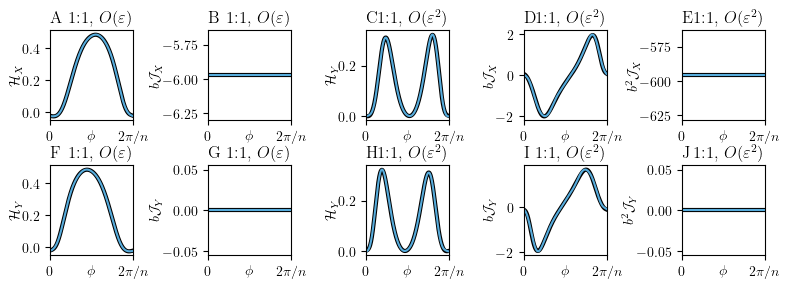

In [18]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 1:2

In [19]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',2),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,100], # [eps, eps^2, etc]
        }
a12 = nm.nmCoupling(**kw_nm)

Initializing 12 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## A

### eps

In [20]:
a = a12
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2387+2*cos(x*2.0)*(-0.0108)+2*cos(x*4.0)*(0.0034)+2*cos(x*6.0)*(0.0011)-2*sin(x*2.0)*(0.0035)-2*sin(x*4.0)*(-0.0048)

het osc 1 order 1, c1 -5.9757


### eps^2

In [21]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0071+2*cos(x*2.0)*(-0.0054)+2*cos(x*4.0)*(0.0025)+2*cos(x*6.0)*(-0.0014)-2*sin(x*2.0)*(-0.0043)-2*sin(x*4.0)*(0.0048)-2*sin(x*6.0)*(-0.0027)

het osc 1 order 2, c1 -0.1353+2*cos(x*2.0)*(0.0771)+2*cos(x*4.0)*(-0.1089)+2*cos(x*8.0)*(0.0128)-2*sin(x*2.0)*(0.1291)-2*sin(x*4.0)*(-0.0791)-2*sin(x*6.0)*(-0.0354)-2*sin(x*8.0)*(-0.0125)

het osc 1 order 2, c2 -595.9792


## B

### eps

In [22]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2387+2*cos(x*2.0)*(-0.1020)+2*cos(x*4.0)*(-0.0046)+2*cos(x*6.0)*(0.0023)-2*sin(x*2.0)*(0.0065)-2*sin(x*4.0)*(0.0014)-2*sin(x*6.0)*(0.0016)

het osc 2 order 1, c1 


### eps^2

In [23]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0382+2*cos(x*4.0)*(-0.0158)+2*cos(x*6.0)*(-0.0031)+2*cos(x*8.0)*(0.0018)-2*sin(x*2.0)*(-0.0185)-2*sin(x*4.0)*(0.0207)-2*sin(x*6.0)*(-0.0011)-2*sin(x*8.0)*(-0.0012)

het osc 2 order 2, c1 +2*cos(x*2.0)*(0.0882)+2*cos(x*4.0)*(0.0308)+2*cos(x*6.0)*(0.0527)+2*cos(x*8.0)*(0.0231)-2*sin(x*2.0)*(1.1301)-2*sin(x*4.0)*(0.1008)-2*sin(x*6.0)*(-0.0749)-2*sin(x*8.0)*(-0.0339)

het osc 2 order 2, c2 


## Plot

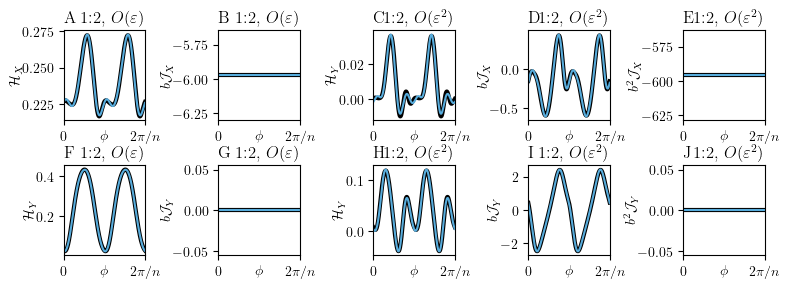

In [24]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 2:1

In [25]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',1),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,100], # [eps, eps^2, etc]
        }
a21 = nm.nmCoupling(**kw_nm)

Initializing 21 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## A

### eps

In [26]:
a = a21
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2387+2*cos(x*2.0)*(-0.1020)+2*cos(x*4.0)*(-0.0046)+2*cos(x*6.0)*(0.0023)-2*sin(x*2.0)*(-0.0065)-2*sin(x*4.0)*(-0.0014)-2*sin(x*6.0)*(-0.0016)

het osc 1 order 1, c1 -5.9757


### eps^2

In [27]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0382+2*cos(x*4.0)*(-0.0158)+2*cos(x*6.0)*(-0.0031)+2*cos(x*8.0)*(0.0018)-2*sin(x*2.0)*(0.0185)-2*sin(x*4.0)*(-0.0207)-2*sin(x*6.0)*(0.0011)-2*sin(x*8.0)*(0.0012)

het osc 1 order 2, c1 -0.1370+2*cos(x*2.0)*(-0.0499)+2*cos(x*6.0)*(-0.0253)+2*cos(x*8.0)*(-0.0118)-2*sin(x*2.0)*(0.6385)-2*sin(x*4.0)*(0.0635)-2*sin(x*6.0)*(-0.0410)-2*sin(x*8.0)*(-0.0180)

het osc 1 order 2, c2 -595.9595


## B

### eps

In [28]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2387+2*cos(x*2.0)*(-0.0108)+2*cos(x*4.0)*(0.0034)+2*cos(x*6.0)*(0.0011)-2*sin(x*2.0)*(-0.0035)-2*sin(x*4.0)*(0.0048)

het osc 2 order 1, c1 


### eps^2

In [29]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0071+2*cos(x*2.0)*(-0.0054)+2*cos(x*4.0)*(0.0025)+2*cos(x*6.0)*(-0.0014)-2*sin(x*2.0)*(0.0043)-2*sin(x*4.0)*(-0.0048)-2*sin(x*6.0)*(0.0027)

het osc 2 order 2, c1 +2*cos(x*2.0)*(-0.0189)+2*cos(x*4.0)*(0.0528)-2*sin(x*2.0)*(0.0617)-2*sin(x*4.0)*(-0.0388)-2*sin(x*6.0)*(-0.0176)

het osc 2 order 2, c2 


## Plot

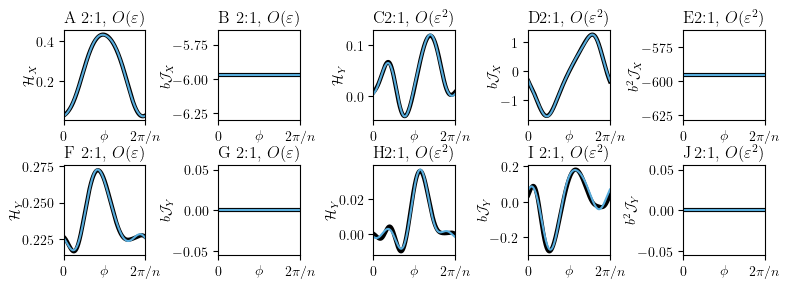

In [30]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 1:3

In [31]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',3),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,100], # [eps, eps^2, etc]
        }
a13 = nm.nmCoupling(**kw_nm)

Initializing 13 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## A

### eps

In [32]:
a = a13
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2387+2*cos(x*3.0)*(0.0030)+2*cos(x*6.0)*(0.0014)-2*sin(x*3.0)*(-0.0115)

het osc 1 order 1, c1 -5.9757


### eps^2

In [33]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 +2*cos(x*3.0)*(0.0065)-2*sin(x*6.0)*(0.0014)

het osc 1 order 2, c1 -0.1353+2*cos(x*3.0)*(-0.1956)+2*cos(x*9.0)*(0.0132)-2*sin(x*3.0)*(-0.0639)-2*sin(x*6.0)*(-0.0476)-2*sin(x*9.0)*(-0.0125)

het osc 1 order 2, c2 -595.9792


## B

### eps

In [34]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2387+2*cos(x*3.0)*(-0.0733)+2*cos(x*6.0)*(-0.0024)-2*sin(x*3.0)*(0.0187)-2*sin(x*6.0)*(0.0010)

het osc 2 order 1, c1 


### eps^2

In [35]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0097+2*cos(x*3.0)*(-0.0075)+2*cos(x*6.0)*(-0.0011)+2*cos(x*9.0)*(-0.0023)-2*sin(x*3.0)*(-0.0370)-2*sin(x*6.0)*(0.0035)

het osc 2 order 2, c1 +2*cos(x*3.0)*(0.3184)+2*cos(x*6.0)*(0.0328)+2*cos(x*9.0)*(0.0326)+2*cos(x*12.0)*(0.0127)-2*sin(x*3.0)*(1.2114)-2*sin(x*6.0)*(0.0811)-2*sin(x*9.0)*(-0.0370)

het osc 2 order 2, c2 


## Plot

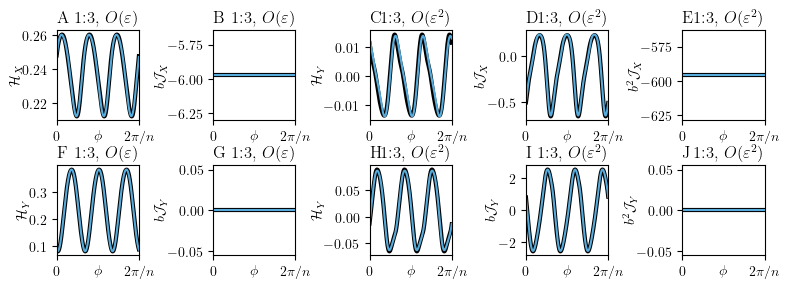

In [36]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 3:1

In [21]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',3),'_m':('om1',1),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,100], # [eps, eps^2, etc]
        }
a31 = nm.nmCoupling(**kw_nm)

Initializing 31 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## A

### eps

In [22]:
a = a31
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2387+2*cos(x*3.0)*(-0.0733)+2*cos(x*6.0)*(-0.0024)-2*sin(x*3.0)*(-0.0187)-2*sin(x*6.0)*(-0.0010)

het osc 1 order 1, c1 -5.9757


### eps^2

In [23]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0097+2*cos(x*3.0)*(-0.0075)+2*cos(x*6.0)*(-0.0011)+2*cos(x*9.0)*(-0.0023)-2*sin(x*3.0)*(0.0370)-2*sin(x*6.0)*(-0.0035)

het osc 1 order 2, c1 -0.1373+2*cos(x*3.0)*(-0.1238)+2*cos(x*9.0)*(-0.0104)-2*sin(x*3.0)*(0.4577)-2*sin(x*6.0)*(0.0348)-2*sin(x*9.0)*(-0.0137)

het osc 1 order 2, c2 -595.9557


## B

### eps

In [24]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2  order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2387+2*cos(x*3.0)*(0.0030)+2*cos(x*6.0)*(0.0014)-2*sin(x*3.0)*(0.0115)

het osc 2  order 1, c1 


### eps^2

In [25]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 +2*cos(x*3.0)*(0.0065)-2*sin(x*6.0)*(-0.0014)

het osc 2 order 2, c1 +2*cos(x*3.0)*(0.0650)-2*sin(x*3.0)*(-0.0184)-2*sin(x*6.0)*(-0.0158)

het osc 2 order 2, c2 


## Plot

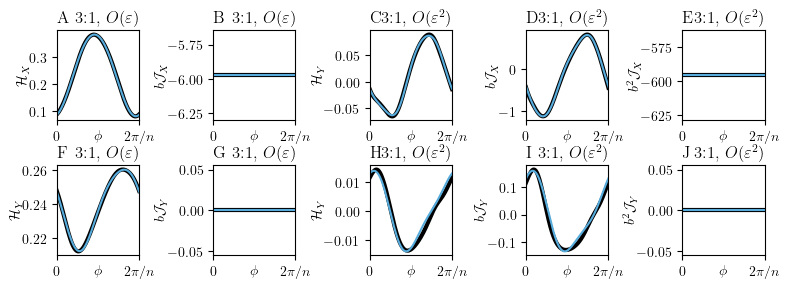

In [42]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)
    
    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 2:3

In [11]:
system1 = rsp(idx=0,model_name='thal0_85_2k',**kws1)
system2 = rsp(idx=1,model_name='thal1_85_2k',**kws1)

mkdir ./data/thal0_85_2k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85_2k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',3),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,2000], # [eps, eps^2, etc]
        }
a23 = nm.nmCoupling(**kw_nm)

Initializing 23 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85_2k, order=0...
* Loading H thal1_85_2k, order=0...
* Loading H thal0_85_2k, order=1...
* Loading H thal1_85_2k, order=1...


## A

### eps

In [13]:
a = a23
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2387+2*cos(x*6.0)*(0.0049)-2*sin(x*6.0)*(-0.0076)

het osc 1 order 1, c1 -5.9757


### eps^2

In [14]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0014+2*cos(x*6.0)*(0.0039)-2*sin(x*6.0)*(0.0020)-2*sin(x*12.0)*(0.0014)

het osc 1 order 2, c1 -0.1370+2*cos(x*6.0)*(-0.1281)-2*sin(x*6.0)*(-0.0933)-2*sin(x*12.0)*(-0.0262)

het osc 1 order 2, c2 -11949.8446


## B

### eps

In [15]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2387+2*cos(x*6.0)*(-0.0063)+2*cos(x*12.0)*(0.0015)-2*sin(x*6.0)*(0.0012)

het osc 2 order 1, c1 


### eps^2

In [16]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=.1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0025+2*cos(x*6.0)*(-0.0003)+2*cos(x*12.0)*(-0.0006)+2*cos(x*18.0)*(-0.0002)-2*sin(x*6.0)*(-0.0021)-2*sin(x*12.0)*(0.0004)-2*sin(x*18.0)*(0.0003)

het osc 2 order 2, c1 +2*cos(x*6.0)*(0.0206)+2*cos(x*12.0)*(0.0319)-2*sin(x*6.0)*(0.1055)-2*sin(x*12.0)*(-0.0503)

het osc 2 order 2, c2 


## Plot

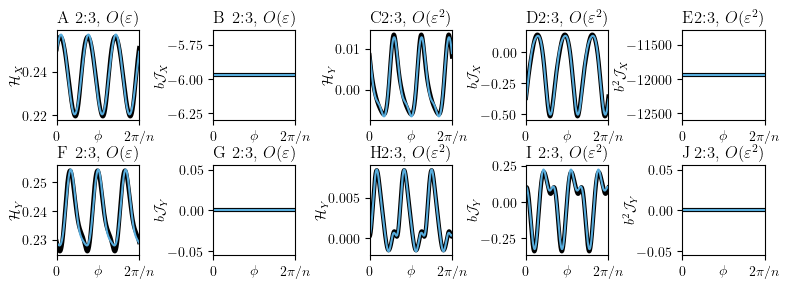

In [17]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

axs[4].ticklabel_format(axis='y', style='sci')

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 3:2

In [32]:
system1 = rsp(idx=0,model_name='thal0_85_2k',**kws1)
system2 = rsp(idx=1,model_name='thal1_85_2k',**kws1)

mkdir ./data/thal0_85_2k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85_2k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [33]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',3),'_m':('om1',2),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,2000], # [eps, eps^2, etc]
        }
a32 = nm.nmCoupling(**kw_nm)

Initializing 32 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85_2k, order=0...
* Loading H thal1_85_2k, order=0...
* Loading H thal0_85_2k, order=1...
* Loading H thal1_85_2k, order=1...


## A

### eps

In [34]:
a = a32
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2387+2*cos(x*6.0)*(-0.0063)+2*cos(x*12.0)*(0.0015)-2*sin(x*6.0)*(-0.0012)

het osc 1 order 1, c1 -5.9757


### eps^2

In [35]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=.1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0025+2*cos(x*6.0)*(-0.0003)+2*cos(x*12.0)*(-0.0006)+2*cos(x*18.0)*(-0.0002)-2*sin(x*6.0)*(0.0021)-2*sin(x*12.0)*(-0.0004)-2*sin(x*18.0)*(-0.0003)

het osc 1 order 2, c1 -0.1373+2*cos(x*12.0)*(-0.0217)-2*sin(x*6.0)*(0.0857)-2*sin(x*12.0)*(-0.0352)

het osc 1 order 2, c2 -11949.8408


## B

### eps

In [36]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2387+2*cos(x*6.0)*(0.0049)-2*sin(x*6.0)*(0.0076)

het osc 2 order 1, c1 


### eps^2

In [37]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=1)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0014+2*cos(x*6.0)*(0.0039)-2*sin(x*6.0)*(-0.0020)-2*sin(x*12.0)*(-0.0014)

het osc 2 order 2, c1 -0.0080+2*cos(x*6.0)*(0.0848)+2*cos(x*12.0)*(-0.0028)+2*cos(x*18.0)*(-0.0042)-2*sin(x*6.0)*(-0.0563)-2*sin(x*12.0)*(-0.0172)-2*sin(x*18.0)*(-0.0026)

het osc 2 order 2, c2 


## Plot

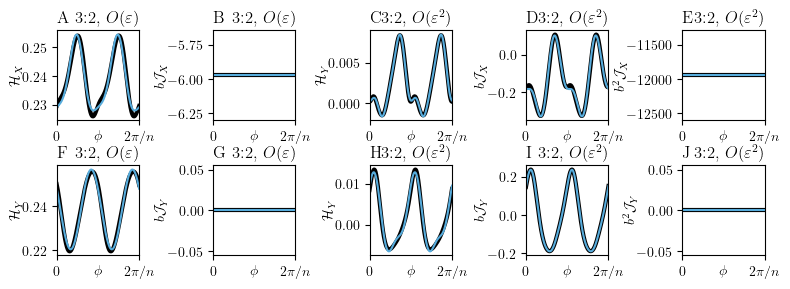

In [38]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

#axs[4].ticklabel_format(axis='y', style='sci')

#axs[4].ticklabel_format(axis='y', style='sci')
# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 3:4

In [25]:
system1 = rsp(idx=0,model_name='thal0_85_1k',**kws1)
system2 = rsp(idx=1,model_name='thal1_85_1k',**kws1)

mkdir ./data/thal0_85_1k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85_1k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [26]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',3),'_m':('om1',4),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,1000], # [eps, eps^2, etc]
        }
a34 = nm.nmCoupling(**kw_nm)

Initializing 34 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85_1k, order=0...
* Loading H thal1_85_1k, order=0...
* Loading H thal0_85_1k, order=1...
* Loading H thal1_85_1k, order=1...


## A

### eps

In [27]:
a = a34
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2387+2*cos(x*12.0)*(0.0031)-2*sin(x*12.0)*(-0.0030)

het osc 1 order 1, c1 -5.9757


### eps^2

In [28]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 +2*cos(x*12.0)*(0.0018)-2*sin(x*12.0)*(0.0021)

het osc 1 order 2, c1 -0.1373+2*cos(x*12.0)*(-0.0691)-2*sin(x*12.0)*(-0.0732)

het osc 1 order 2, c2 -5974.1118


## B

### eps

In [29]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2387+2*cos(x*12.0)*(0.0038)-2*sin(x*12.0)*(0.0032)

het osc 2 order 1, c1 


### eps^2

In [30]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0051+2*cos(x*12.0)*(-0.0016)

het osc 2 order 2, c1 +2*cos(x*12.0)*(0.0718)-2*sin(x*12.0)*(-0.0851)-2*sin(x*24.0)*(-0.0099)

het osc 2 order 2, c2 


## Plot

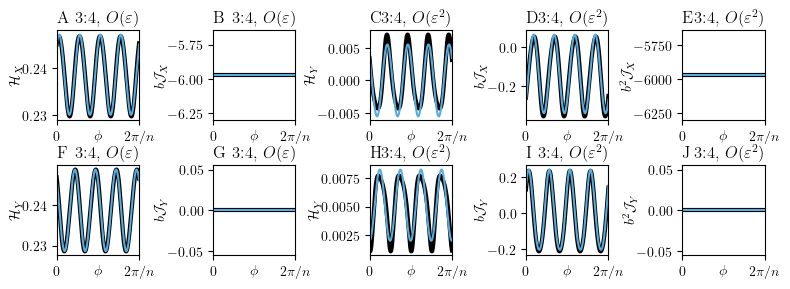

In [31]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 4:3

In [39]:
system1 = rsp(idx=0,model_name='thal0_85_1k',**kws1)
system2 = rsp(idx=1,model_name='thal1_85_1k',**kws1)

mkdir ./data/thal0_85_1k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85_1k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [40]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',4),'_m':('om1',3),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,1000], # [eps, eps^2, etc]
        }
a43 = nm.nmCoupling(**kw_nm)

Initializing 43 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=1
p order=1
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_85_1k, order=0...
* Computing H thal1_85_1k, order=0...
* Computing H thal0_85_1k, order=1...
* Computing H thal1_85_1k, order=1...


## A

### eps

In [41]:
a = a43
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2342+2*cos(x*12.0)*(0.0038)-2*sin(x*12.0)*(-0.0031)

het osc 1 order 1, c1 -5.9757


### eps^2

In [42]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0049+2*cos(x*12.0)*(-0.0015)

het osc 1 order 2, c1 -0.1352+2*cos(x*12.0)*(-0.0510)-2*sin(x*12.0)*(-0.0692)

het osc 1 order 2, c2 -5974.1083


## B

### eps

In [43]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2342+2*cos(x*12.0)*(0.0031)-2*sin(x*12.0)*(0.0029)

het osc 2 order 1, c1 


### eps^2

In [44]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 +2*cos(x*12.0)*(0.0018)-2*sin(x*12.0)*(-0.0020)

het osc 2 order 2, c1 +2*cos(x*12.0)*(0.0486)-2*sin(x*12.0)*(-0.0520)

het osc 2 order 2, c2 


## Plot

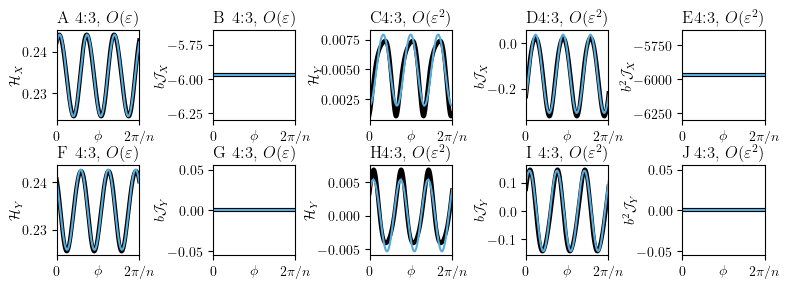

In [45]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
    
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs